In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy import table
from astropy.io import fits

from ekfplot import plot as ek

from agrias import utils
import reader

In [3]:
merian = table.Table(fits.getdata('/Users/kadofong/Downloads/Merian_DR1_photoz_EAZY_v1.2.fits',1))
ms = reader.merianselect ( merian )
_galex = reader.galexcrossmatch ()
overlap = ms.index.intersection(_galex.index)

merian_sources = ms.reindex(overlap)

_galex = _galex.sort_values('fuv_exptime', ascending=False)

galex = _galex.loc[~_galex.index.duplicated(keep='first')].reindex(overlap).reset_index()

[merianselect] Only choosing sources at 0.070<z_phot<0.090
[merianselect] Only choosing sources with i_cModelmag_Merian < 22.0
[merianselect] only choosing sources with cmodel/gaap(i) > 1.3


In [4]:
catalog_halum = pd.read_csv ( '/Users/kadofong/Desktop/merian_catalog_halum.csv', index_col=0)

In [5]:
lha_df = pd.read_csv('../local_data/output/lha_df.csv', index_col=0)
lha_df = lha_df.reindex(merian_sources.index)

/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


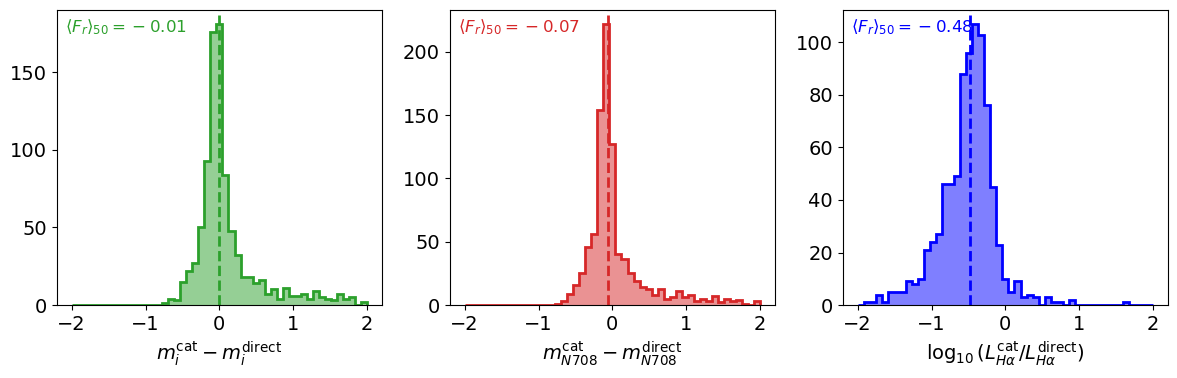

In [11]:
fig, axarr = plt.subplots(1,3,figsize=(12,4))
catalog_apercorr = merian_sources['i_cModelFlux_Merian'] / merian_sources['i_gaap1p0Flux_Merian']
f2m = lambda x, zp = 31.4: -2.5*np.log10(x*catalog_apercorr) + zp
ratios = [
    merian_sources['i_cModelmag_Merian'] - lha_df.reindex(merian_sources.index)['imag'],
    f2m(merian_sources['N708_gaap1p0Flux_Merian']) - lha_df.reindex(merian_sources.index)['n708mag'],    
    np.log10(catalog_halum['LHa']/1e40/lha_df.reindex(catalog_halum.index)['LHa']),
    #np.log10(calibrations.SFR2LHa(10.**merian_sources['logsfr_gaap1p0']) / (lha_df['LHa']*1e40) )
]
colorlist = [
    'tab:green',
    'tab:red',
    'b'
]
labels = [
    r'$m_i^{\rm cat} - m_i^{\rm direct}$',
    r'$m_{N708}^{\rm cat} - m_{N708}^{\rm direct}$',
    r'$\log_{10}(L_{H\alpha}^{\rm cat}/L_{H\alpha}^{\rm direct})$'
]

for idx, ax in enumerate(axarr):
    ek.hist( 
        ratios[idx],
        bins=np.linspace(-2.,2.,50),
        ax=axarr[idx],
        color=colorlist[idx],
        alpha=0.5,
        lw=2
    )    
    axarr[idx].axvline(
        np.nanmedian(ratios[idx]),
        color=colorlist[idx],
        lw=2,
        ls='--'
    )
    ek.text(
        0.025,
        0.975,        
        r'$\langle F_r \rangle_{50} = %.2f$' % np.nanmedian(ratios[idx]),
        ax=axarr[idx],
        color=colorlist[idx],
        fontsize=12
    )
    axarr[idx].set_xlabel(labels[idx])   
plt.tight_layout ()
plt.savefig('../../../sfr_calibrators/figures/data_validation/photometric_offsets.png')

In [12]:
from ekfphys import calibrations, observer
from ekfparse import query

In [13]:
rv = 3.1
ge_av = merian_sources['ebv_Merian']*rv

In [14]:
gecorr = np.zeros([len(ge_av),2])
for idx,row in enumerate(ge_av.values):
    gecorr[idx] = -observer.gecorrection(np.array([4758.71,6135.]), row, return_magcorr=True)


In [15]:
ref = np.genfromtxt('/Users/kadofong/Desktop/ref.txt')

Text(0, 0.5, 'g-r')

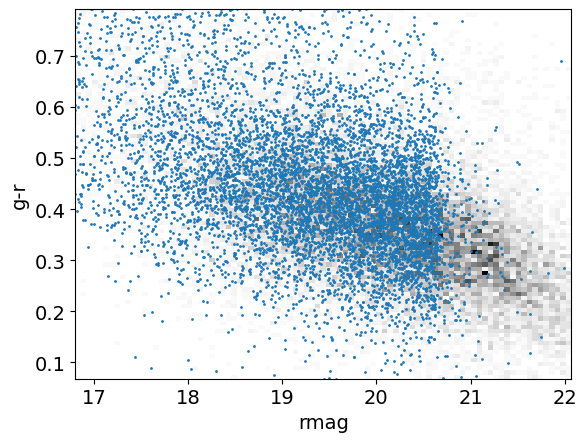

In [16]:
apercorr = merian_sources['i_cModelFlux_Merian']/merian_sources['i_gaap1p0Flux_Merian']
flux = merian_sources.loc[:,utils.photcols['r']]*apercorr
gr = -2.5*np.log10(merian_sources[utils.photcols['g']]/merian_sources[utils.photcols['r']]) + gecorr[:,0] - gecorr[:,1]
merian_rmag = -2.5*np.log10(flux) + 31.4

_=ek.hist2d(
    merian_rmag,
    gr,
    bins=90, 
)
plt.scatter(
    ref[3],
    ref[2]-ref[3],
    s=1,
)
#plt.xlim(7., 11.2)
plt.xlabel('rmag')
plt.ylabel('g-r')

In [22]:
lee = table.Table.read('/Users/kadofong/work/projects/literature_ref/lee2009/tab1_processed.txt', format='mrt')
leer = lee['loghalum'] - lee['loguvlum']

In [35]:
leer.shape

(315,)

In [46]:
ll = ''
dirstem = '/scratch/gpfs/kadofong/merian/cutouts/galex_MDR1/hsc/'
for band in 'grizy':
    for tp in ['image','psf']:
        if tp=='psf':
            suffix='_psf'
        else:
            suffix=''
        print(f'mv {dirstem}J*{band}{suffix}.fits {dirstem}hsc_{band}/{tp}/')
print(ll)

mv /scratch/gpfs/kadofong/merian/cutouts/galex_MDR1/hsc/J*g.fits /scratch/gpfs/kadofong/merian/cutouts/galex_MDR1/hsc/hsc_g/image/
mv /scratch/gpfs/kadofong/merian/cutouts/galex_MDR1/hsc/J*g_psf.fits /scratch/gpfs/kadofong/merian/cutouts/galex_MDR1/hsc/hsc_g/psf/
mv /scratch/gpfs/kadofong/merian/cutouts/galex_MDR1/hsc/J*r.fits /scratch/gpfs/kadofong/merian/cutouts/galex_MDR1/hsc/hsc_r/image/
mv /scratch/gpfs/kadofong/merian/cutouts/galex_MDR1/hsc/J*r_psf.fits /scratch/gpfs/kadofong/merian/cutouts/galex_MDR1/hsc/hsc_r/psf/
mv /scratch/gpfs/kadofong/merian/cutouts/galex_MDR1/hsc/J*i.fits /scratch/gpfs/kadofong/merian/cutouts/galex_MDR1/hsc/hsc_i/image/
mv /scratch/gpfs/kadofong/merian/cutouts/galex_MDR1/hsc/J*i_psf.fits /scratch/gpfs/kadofong/merian/cutouts/galex_MDR1/hsc/hsc_i/psf/
mv /scratch/gpfs/kadofong/merian/cutouts/galex_MDR1/hsc/J*z.fits /scratch/gpfs/kadofong/merian/cutouts/galex_MDR1/hsc/hsc_z/image/
mv /scratch/gpfs/kadofong/merian/cutouts/galex_MDR1/hsc/J*z_psf.fits /scratch

(<Axes: >,
 (array([0.        , 0.03816526, 0.05724788, 0.02862394, 0.07633051,
         0.08587183, 0.15266102, 0.20990891, 0.4102765 , 0.69651592,
         1.28807739, 1.29761871, 1.34532528, 0.80147038, 0.4770657 ,
         0.23853285, 0.10495445, 0.10495445, 0.04770657]),
  array([11.34302436, 11.47704913, 11.61107389, 11.74509866, 11.87912343,
         12.01314819, 12.14717296, 12.28119772, 12.41522249, 12.54924725,
         12.68327202, 12.81729679, 12.95132155, 13.08534632, 13.21937108,
         13.35339585, 13.48742061, 13.62144538, 13.75547015, 13.88949491]),
  [<matplotlib.patches.Polygon at 0x1485abd60>]))

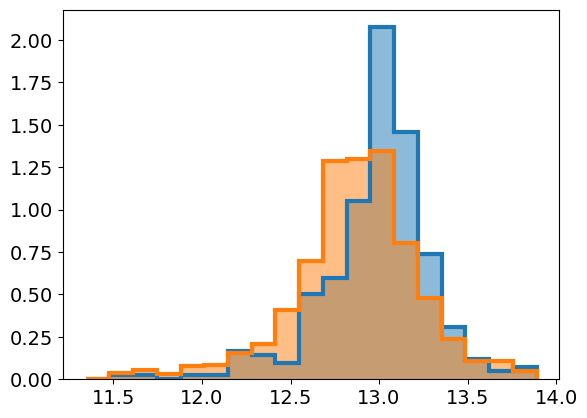

In [34]:
out=ek.hist(
    leer,
    density=True,
    bins=20,
    alpha=0.5,
    binalpha=0.001,
    lw=3
)

ek.hist(
    np.log10(lha_df['LHa']*1e40 / catalog_halum.reindex(lha_df.index)['LFUV']),
    density=True,
    bins=out[1][1],
    alpha=0.5,
    lw=3
)

In [30]:
out

(<Axes: >,
 (array([0.        , 0.03456578, 0.24196046, 0.06913156, 0.20739468,
         0.06913156, 0.27652624, 0.58761827, 0.69131561, 0.96784185,
         2.00481527, 1.83198636, 1.65915746, 0.89871029, 0.51848671,
         0.20739468, 0.13826312, 0.1728289 , 0.03456578]),
  array([11.96792887, 12.06216453, 12.15640019, 12.25063584, 12.3448715 ,
         12.43910715, 12.53334281, 12.62757846, 12.72181412, 12.81604978,
         12.91028543, 13.00452109, 13.09875674, 13.1929924 , 13.28722806,
         13.38146371, 13.47569937, 13.56993502, 13.66417068, 13.75840633]),
  [<matplotlib.patches.Polygon at 0x13f596140>]))